In [112]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler, SequentialSampler

import numpy as np
import matplotlib.pyplot as plt

In [113]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 20
batch_size = 500
learning_rate = 0.1

In [119]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='StandardData', 
                                          train=False, 
                                          transform=transforms.ToTensor())


subsample_train_indices = torch.randperm(len(train_dataset))[:10000]
subsample_test_indices = torch.randperm(len(test_dataset))[:2000]

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(subsample_train_indices))

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(subsample_test_indices)) 

In [120]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        return x

In [163]:
# Train the model

model_RealData = NeuralNet(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_RealData.parameters(), lr=learning_rate) 

def train_epoch():
    gradients=[]
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model_RealData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        batch_gradients=[]
        for ten in model_RealData.fc1.weight.grad:
            batch_gradients+=ten.tolist()
        batch_gradients+=model_RealData.fc1.bias.grad.tolist()
        for ten in model_RealData.fc2.weight.grad:
            batch_gradients+=ten.tolist()
        batch_gradients+=model_RealData.fc2.bias.grad.tolist()
        optimizer.step()
        gradients.append(np.array(batch_gradients))
    expected_gradient=np.zeros(len(gradients[0]))
    expected_dot=0
    n=len(gradients)
    for grad in gradients:
        expected_gradient+=grad/n
        expected_dot+=np.dot(grad,grad)
    batchwise_coherence=np.dot(expected_gradient,expected_gradient)/expected_dot
    k=len(train_loader)
    perexample_coherence=batchwise_coherence/(k-(k-1)*batchwise_coherence)
    return loss.item(), perexample_coherence*10000

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            outputs = model_RealData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

train_loss=[]
train_accuracy=[]
test_loss=[]
test_accuracy=[]
epoch_list=[]
alpha_list=[]

for epoch in range(2):
    trainloss, alpha = train_epoch()
    train_loss.append(trainloss)
    alpha_list.append(alpha)
    train_accuracy.append(accuracy(train_loader))
    test_loss.append(loss(test_loader))
    test_accuracy.append(accuracy(test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f} Coherence: {:.3f}'.format(epoch+1,train_loss[-1],test_loss[-1],train_accuracy[-1],test_accuracy[-1],alpha_list[-1]))

Epoch: 1 TrainLoss: 1.489 TestLoss: 1.430 TrainAccuracy: 0.777 TestAccuracy: 0.782 Coherence: 19.983
Epoch: 2 TrainLoss: 0.881 TestLoss: 0.882 TrainAccuracy: 0.832 TestAccuracy: 0.826 Coherence: 17.506


Text(0.5, 1.0, 'Accuracy')

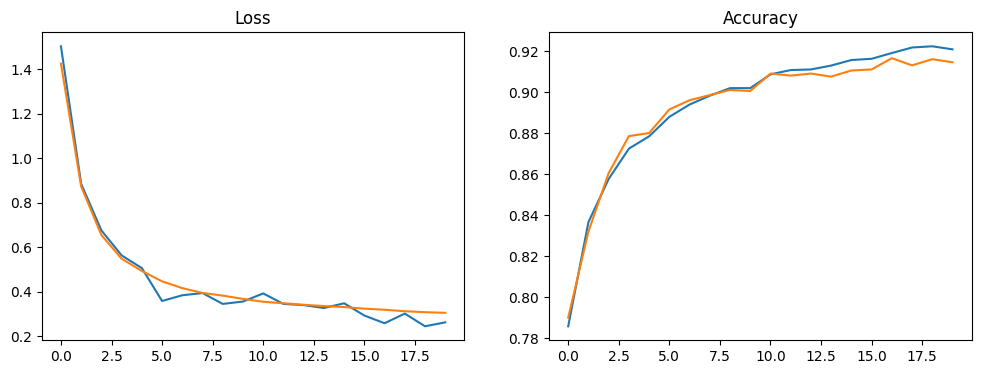

In [122]:
fig, axs = plt.subplots(1,2)

fig.set_size_inches(12,4)

axs[0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0].set_title('Loss')
axs[1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[1].set_title('Accuracy')

In [141]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 20
batch_size = 20
learning_rate = 0.1

In [142]:
# MNIST dataset 
random_train_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           target_transform=lambda y: torch.randint(0, 10, (1,)).item(), 
                                           download=True)

random_test_dataset = torchvision.datasets.MNIST(root='ShuffledData', 
                                          train=False, 
                                          transform=transforms.ToTensor(),
                                          target_transform=lambda y: torch.randint(0, 10, (1,)).item())

subsample_train_indices = torch.randperm(len(random_train_dataset))[:10000]
subsample_test_indices = torch.randperm(len(random_test_dataset))[:2000]

# Data loader
random_train_loader = DataLoader(dataset=random_train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(subsample_train_indices))

random_test_loader = DataLoader(dataset=random_test_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(subsample_test_indices)) 

In [143]:
model_RandomData = NeuralNet(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_RandomData.parameters(), lr=learning_rate) 

def train_epoch():
    for images, labels in random_train_loader:  
        images = images.reshape(-1, 28*28)
        outputs = model_RandomData(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

def accuracy(loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return correct/total

def loss(loader):
    with torch.no_grad():
        loss = 0
        total = 0
        for images, labels in loader:
            images = images.reshape(-1, 28*28)
            labels = labels
            outputs = model_RandomData(images)
            loss += criterion(outputs, labels).item()*labels.size(0)
            total += labels.size(0)
        return loss/total

random_train_loss=[]
random_train_accuracy=[]
random_test_loss=[]
random_test_accuracy=[]

for epoch in range(num_epochs):
    random_train_loss.append(train_epoch())
    random_train_accuracy.append(accuracy(random_train_loader))
    random_test_loss.append(loss(random_test_loader))
    random_test_accuracy.append(accuracy(random_test_loader))
    print('Epoch: {} TrainLoss: {:.3f} TestLoss: {:.3f} TrainAccuracy: {:.3f} TestAccuracy: {:.3f}'.format(epoch+1,random_train_loss[-1],random_test_loss[-1],random_train_accuracy[-1],random_test_accuracy[-1]))

Epoch: 1 TrainLoss: 2.343 TestLoss: 2.307 TrainAccuracy: 0.099 TestAccuracy: 0.106
Epoch: 2 TrainLoss: 2.324 TestLoss: 2.304 TrainAccuracy: 0.103 TestAccuracy: 0.101
Epoch: 3 TrainLoss: 2.283 TestLoss: 2.307 TrainAccuracy: 0.097 TestAccuracy: 0.101
Epoch: 4 TrainLoss: 2.339 TestLoss: 2.306 TrainAccuracy: 0.098 TestAccuracy: 0.104
Epoch: 5 TrainLoss: 2.313 TestLoss: 2.305 TrainAccuracy: 0.104 TestAccuracy: 0.096
Epoch: 6 TrainLoss: 2.293 TestLoss: 2.305 TrainAccuracy: 0.105 TestAccuracy: 0.087
Epoch: 7 TrainLoss: 2.325 TestLoss: 2.304 TrainAccuracy: 0.102 TestAccuracy: 0.086
Epoch: 8 TrainLoss: 2.327 TestLoss: 2.305 TrainAccuracy: 0.100 TestAccuracy: 0.104
Epoch: 9 TrainLoss: 2.307 TestLoss: 2.306 TrainAccuracy: 0.101 TestAccuracy: 0.106
Epoch: 10 TrainLoss: 2.312 TestLoss: 2.304 TrainAccuracy: 0.103 TestAccuracy: 0.105


KeyboardInterrupt: 

Text(0.5, 1.0, 'Accuracy')

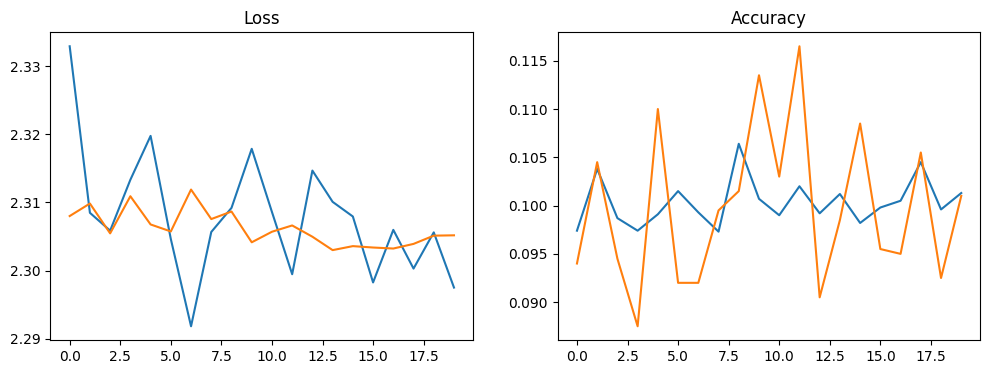

In [130]:
fig, axs = plt.subplots(1,2)

fig.set_size_inches(12,4)

axs[0].plot(np.arange(num_epochs), random_train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), random_test_loss,label='Test')
axs[0].set_title('Loss')
axs[1].plot(np.arange(num_epochs), random_train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), random_test_accuracy,label='Test')
axs[1].set_title('Accuracy')

Text(0.5, 1.0, 'Accuracy')

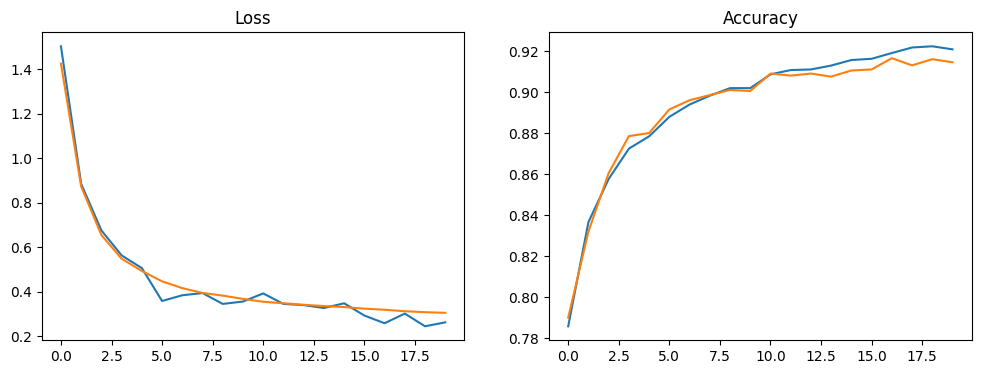

In [131]:
fig, axs = plt.subplots(1,2)

fig.set_size_inches(12,4)

axs[0].plot(np.arange(num_epochs), train_loss,label='Train')
axs[0].plot(np.arange(num_epochs), test_loss,label='Test')
axs[0].set_title('Loss')
axs[1].plot(np.arange(num_epochs), train_accuracy,label='Train')
axs[1].plot(np.arange(num_epochs), test_accuracy,label='Test')
axs[1].set_title('Accuracy')

In [ ]:
def network_layer_weight_extraction(model):
    network_weights=[]
    for para in list(model.named_parameters()):
        list_para=list(para)
        if 'weight' in list_para[0]:
            list_weights=list(list_para[1])
            layer_weights=[]
            for row in list_weights:
                row_list=row.tolist()
                layer_weights.append(row_list)
            network_weights.append(np.array(layer_weights))
    return network_weights